In [1]:
!pip install pandas_ta
!pip install neat-python

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
use_collab = True
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'

In [23]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import multiprocessing
import matplotlib.pyplot as plt
import random
import neat
import string
import gzip
import pickle
import time
import os
from neat.checkpoint import Checkpointer


In [5]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [6]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


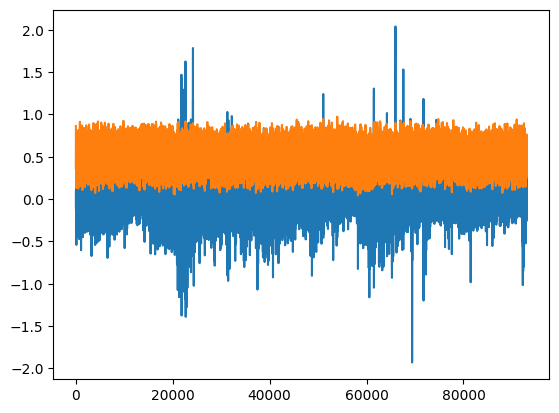

In [7]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [8]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [9]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [10]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [11]:
act_check = np.zeros(4)
act_check[1] = 1
act_check[2] = 1

print(np.sum(act_check)==2)

True


In [101]:
from numpy.random.mtrand import randint
def run_env_loop(net,rand,debug,ep_len,total_val):
    trade_info = np.zeros(6)
    returns = np.array([])
    act_check = np.zeros(4)

    trade_timer = 0
    trade_value = 0.0
    trade_direction = 0
    cash_out_val = 0
    acount_bal = 0
    trade_max = 0
    trade_risk = 0
    time_at_max = 0



    for count in range(rand, rand+ep_len):
        state = np.concatenate((INDICATORS[count],trade_info))
        outputs = net.activate(state)
        risk =  np.clip(abs(outputs[4]), .01, 1)
        action = np.argmax(outputs[:4])
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count+1]
        cash_out_val = 0
        random = randint(0,10)

        if buy:
          cash_out_val = trade_value*trade_risk
          trade_risk = risk
          trade_value = (cur_move*1)
          trade_direction = 1
          trade_timer = 0
          trade_max = trade_value
          time_at_max = 0
          act_check[0] = 1
        elif sell:
          cash_out_val = trade_value*trade_risk
          trade_risk = risk
          trade_value = (cur_move*-1)
          trade_direction = -1
          trade_timer = 0
          trade_max = trade_value
          time_at_max = 0
          act_check[1] = 1
        elif cash_out:
          cash_out_val = trade_value*trade_risk
          trade_timer = 0 if trade_direction != 0 else trade_timer+.05
          trade_value = 0
          trade_direction = 0
          trade_max = 0
          time_at_max = 0
          trade_risk = 0
          act_check[2] = 1
        else:
          trade_value += (cur_move*trade_direction)
          trade_timer += .05
          trade_max = max(trade_max,trade_value)
          time_at_max = 0 if trade_value==trade_max else time_at_max+0.05
          act_check[3] = 1



        acount_bal += cash_out_val
        if buy or sell:
          acount_bal -= .1


        trade_info = np.array((trade_value,trade_direction,trade_timer,trade_max,trade_risk,time_at_max))


        if debug:
          print(trade_info)

        if acount_bal<-100:
          return -1
        elif trade_timer>2 and random == 2:
          return -1

    acount_bal += trade_value
    return acount_bal/total_val if np.sum(act_check) == 4 else -1

In [102]:
def eval_genomes(genomes, config):
  rand = random.randint(1000, 60000)
  ep_len = 1000
  sliced_arr = change[rand:rand+ep_len]
  total_val = sum(abs(sliced_arr))
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False,ep_len,total_val)



In [103]:
def eval_genome_parallel(genome,config):
  rand = 10000 #random.randint(1000, 60000)
  ep_len = 1000
  sliced_arr = change[rand:rand+ep_len]
  total_val = sum(abs(sliced_arr))
  genome.fitness = 0.0
  net = neat.nn.FeedForwardNetwork.create(genome, config)
  fitness = run_env_loop(net,rand,False,ep_len,total_val)
  return fitness


In [70]:
use_checkpoint = False

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)
if use_checkpoint:
  checkpoint_file = '/content/drive/MyDrive/neat/newcheckpoint/789'
  p = Checkpointer.restore_checkpoint(checkpoint_file)
else:
  p = neat.Population(config)


p.add_reporter(neat.StdOutReporter(False))


In [71]:
p.add_reporter(neat.Checkpointer(generation_interval=100,filename_prefix="/content/drive/MyDrive/neat/newcheckpoint/"))

In [105]:
parallel = False
if parallel:
  pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome_parallel)
  winner = p.run(pe.evaluate, 10000)
else:
  winner = p.run(eval_genomes,1)


 ****** Running generation 2485 ****** 

Population's average fitness: -0.57222 stdev: 0.49639
Best fitness: 0.10012 - size: (31, 41) - species 162 - id 358181
Average adjusted fitness: 0.388
Mean genetic distance 2.631, standard deviation 0.458
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 16.691 sec (10.015 average)


In [121]:
net = neat.nn.FeedForwardNetwork.create(winner, config)
np.set_printoptions(formatter={'float': lambda x: "{:.4f}".format(x)})
rand = random.randint(1000, 60000)
ep_len = 1000
sliced_arr = change[rand:rand+ep_len]
total_val = sum(abs(sliced_arr))
run_env_loop(net,rand,True,ep_len,total_val)

[0.3378 1.0000 0.0000 0.3378 1.0000 0.0000]
[-0.0186 1.0000 0.0500 0.3378 1.0000 0.0500]
[0.2003 1.0000 0.1000 0.3378 1.0000 0.1000]
[0.4942 1.0000 0.1500 0.4942 1.0000 0.0000]
[0.1504 1.0000 0.2000 0.4942 1.0000 0.0500]
[0.3880 1.0000 0.2500 0.4942 1.0000 0.1000]
[0.1067 1.0000 0.3000 0.4942 1.0000 0.1500]
[-0.7126 1.0000 0.3500 0.4942 1.0000 0.2000]
[-2.8787 1.0000 0.4000 0.4942 1.0000 0.2500]
[-2.9916 1.0000 0.4500 0.4942 1.0000 0.3000]
[-4.1405 1.0000 0.5000 0.4942 1.0000 0.3500]
[-2.8140 1.0000 0.5500 0.4942 1.0000 0.4000]
[-3.6927 1.0000 0.6000 0.4942 1.0000 0.4500]
[-2.5806 1.0000 0.6500 0.4942 1.0000 0.5000]
[-1.8716 1.0000 0.7000 0.4942 1.0000 0.5500]
[-0.8309 1.0000 0.7500 0.4942 1.0000 0.6000]
[-1.1251 1.0000 0.8000 0.4942 1.0000 0.6500]
[-1.0061 1.0000 0.8500 0.4942 1.0000 0.7000]
[-1.1126 1.0000 0.9000 0.4942 1.0000 0.7500]
[-1.9644 1.0000 0.9500 0.4942 1.0000 0.8000]
[-0.5161 1.0000 1.0000 0.4942 1.0000 0.8500]
[0.2600 1.0000 1.0500 0.4942 1.0000 0.9000]
[-0.0213 1.0000 1

0.017477040487431487

In [ ]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [ ]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [ ]:
print(winner)

In [ ]:
for item in node_list:
       print(item)